In [1]:
import pulp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
distance_matrix = pd.read_csv('dataset/Distance_Matrix.csv').drop('Unnamed: 0', axis=1)
biomass_history = pd.read_csv('dataset/Biomass_History.csv')


### Detalhes:

- *Variáveis de Decisão*: As variáveis `x`, `y`, `depot`, e `refinery` representam as decisões de alocação e seleção.
- *Função Objetivo*: A função objetivo combina o custo de transporte e a incompatibilidade da previsão de biomassa.
- *Restrições*: As restrições garantem que cada local de colheita seja atribuído a um depósito, cada depósito a uma refinaria, e outras restrições específicas do problema.

Este código é um esboço geral e pode precisar de ajustes e detalhamento adicionais com base nos dados e requisitos específicos do problema.

In [8]:
year = '2011'
B = biomass_history[year].to_numpy()
D = distance_matrix.to_numpy()
C = 20_000

num_warehouses = 25
num_harvesting_sites = 500

In [9]:
distance_matrix

0         1         2         3         4         5         6  \
0       0.0000   11.3769   20.4557   38.1227   45.3810   54.9915   78.6108   
1      11.3769    0.0000    9.0788   28.9141   36.1724   45.7829   69.4022   
2      20.4557    9.0788    0.0000   22.3791   29.6374   39.2478   62.8671   
3      38.1227   28.9141   22.3791    0.0000   11.8343   23.5413   41.8396   
4      45.3810   36.1724   29.6374   11.8343    0.0000   11.7070   24.3986   
...        ...       ...       ...       ...       ...       ...       ...   
2413  671.2005  668.9528  669.5556  669.9084  652.1102  640.4032  627.7116   
2414  663.4455  661.1978  661.8006  662.1534  644.3551  632.6481  619.9566   
2415  663.7748  661.5271  662.1298  662.4826  644.6844  632.9774  620.2859   
2416  671.0165  668.7688  669.3715  669.7244  651.9261  640.2191  627.5276   
2417  679.2328  676.9851  677.5878  677.9406  660.1424  648.4354  635.7439   

             7         8         9  ...      2408      2409      2410  \
0     118.6750  102.6639  113.4309  ...  683.8771  687.6310  697.3246   
1      78.2329   93.4553  111.1832  ...  681.6295  685.3833  695.0769   
2      71.6979   86.9203  111.7859  ...  682.2323  685.9861  695.6796   
3      50.6703   65.8927   82.5852  ...  681.4226  685.1765  694.8701   
4      33.2293   53.9901   65.1442  ...  663.9816  667.7355  677.4291   
...        ...       ...       ...  ...       ...       ...       ...   
2413  622.9663  638.9532  617.7221  ...  109.0007  112.7545  122.4481   
2414  615.2112  631.1981  609.9671  ...  101.2456  104.9995  114.6931   
2415  615.5405  631.5274  610.2964  ...   84.1469   87.9008   97.5943   
2416  622.7822  638.7691  617.5381  ...   91.3886   95.1425  104.8361   
2417  630.9985  646.9854  625.7544  ...   99.6049  103.3587  113.0523   

          2411      2412      2413      2414      2415      2416      2417  
0     669.3962  667.6788  665.5775  662.0291  665.9655  673.2073  681.4235  
1     667.1485  665.4311  663.3298  659.7815  663.7178  670.9596  679.1758  
2     667.7513  666.0339  663.9326  660.3843  664.3206  671.5623  679.7786  
3     666.9417  665.2243  663.1230  659.5746  663.5110  670.7528  678.9690  
4     649.5007  647.7833  645.6820  642.1336  646.0700  653.3118  661.5280  
...        ...       ...       ...       ...       ...       ...       ...  
2413   12.3091    9.1558    0.0000   14.5629   22.3860   36.6284   44.8446  
2414   26.4955   23.3422   14.1864    0.0000   14.5984   28.8407   37.0570  
2415   34.3098   31.1565   22.0007   12.8105    0.0000   14.2423   22.4586  
2416   48.5521   45.3988   36.2430   27.0528   14.2423    0.0000   12.4741  
2417   56.7684   53.6151   44.4593   35.2691   22.4586   12.4741    0.0000  

[2418 rows x 2418 columns]

In [10]:
def print_matrix(matrix):
    print(pd.DataFrame(matrix).to_string(index=True, header=True))

print_matrix(D[:5, :5])

         0        1        2        3        4
0   0.0000  11.3769  20.4557  38.1227  45.3810
1  11.3769   0.0000   9.0788  28.9141  36.1724
2  20.4557   9.0788   0.0000  22.3791  29.6374
3  38.1227  28.9141  22.3791   0.0000  11.8343
4  45.3810  36.1724  29.6374  11.8343   0.0000


In [14]:
import pulp

warehouse_locations = [j for j in range(num_harvesting_sites)]
harvesting_sites = [i for i in range(num_harvesting_sites)]

In [15]:
x = pulp.LpVariable.dicts('x%s_y%s', (harvesting_sites, warehouses_locations), cat=pulp.LpBinary)
y = pulp.LpVariable.dicts('y_%s', warehouses_locations, cat=pulp.LpBinary)

In [16]:
# Creates the 'prob' variable to contain the problem data
prob = pulp.LpProblem("P-Median", pulp.LpMinimize)

cost_of_transportation = pulp.lpSum([(x[i][j] * (B[i] * D[i][j]) for j in warehouse_locations) for i in harvesting_sites])
cost_of_underutilization = pulp.lpSum([(C - pulp.lpSum([x[i][j] for i in harvesting_sites])) for j in warehouse_locations])
a= 0.001
b=1
prob += a * cost_of_transportation + b * cost_of_underutilization

In [17]:
# Constraints

# Constraint 1: Number of warehouses must be less or equal to the maximum number of warehouses
prob += (
    pulp.lpSum([y[j] for j in warehouse_locations]) == num_warehouses, 
    "Maximum_number_of_warehouses"
    )

# Constraint 2: Each harvesting site must be assigned to exactly one warehouse
for i in harvesting_sites:
    prob += (
        pulp.lpSum([x[i][j] for j in warehouse_locations]) == 1,
        f"Harvesting_site_{i}_must_be_assigned_to_exactly_one_warehouse"
    )

# Constraint 3: If a harvesting site is assigned to a warehouse, the warehouse must be selected
for i in harvesting_sites:
    for j in warehouse_locations:
        prob += (
            x[i][j] <= y[j],
            f"Harvesting_site_{i}_must_be_assigned_to_warehouse_{j}_only_if_warehouse_{j}_is_selected"
        )

# Constraint 4: Limit the capacity of each warehouse
for j in warehouse_locations:
    prob += (
        pulp.lpSum([x[i][j] * B[i] for i in harvesting_sites]) <= C,
        f"Limit_the_capacity_of_warehouse_{j}"
    )


In [18]:
prob.solve()

1

In [20]:
# print the status of the solution
print("Status:", pulp.LpStatus[prob.status])

if pulp.LpStatus[prob.status] == "Optimal":
    print("Objective = ", pulp.value(prob.objective))
    print("Variables:")
    for v in prob.variables():
        print(v.name, "=", v.varValue)
else:
    print("No optimal solution found.")

Status: Optimal
Objective =  9999500.0
Variables:
x0_y0 = 0.0
x0_y1 = 0.0
x0_y10 = 0.0
x0_y100 = 0.0
x0_y101 = 0.0
x0_y102 = 0.0
x0_y103 = 0.0
x0_y104 = 0.0
x0_y105 = 0.0
x0_y106 = 0.0
x0_y107 = 0.0
x0_y108 = 0.0
x0_y109 = 0.0
x0_y11 = 0.0
x0_y110 = 0.0
x0_y111 = 0.0
x0_y112 = 0.0
x0_y113 = 0.0
x0_y114 = 0.0
x0_y115 = 0.0
x0_y116 = 0.0
x0_y117 = 0.0
x0_y118 = 0.0
x0_y119 = 0.0
x0_y12 = 0.0
x0_y120 = 0.0
x0_y121 = 0.0
x0_y122 = 0.0
x0_y123 = 0.0
x0_y124 = 0.0
x0_y125 = 0.0
x0_y126 = 0.0
x0_y127 = 0.0
x0_y128 = 0.0
x0_y129 = 0.0
x0_y13 = 0.0
x0_y130 = 0.0
x0_y131 = 0.0
x0_y132 = 0.0
x0_y133 = 0.0
x0_y134 = 0.0
x0_y135 = 0.0
x0_y136 = 0.0
x0_y137 = 0.0
x0_y138 = 0.0
x0_y139 = 0.0
x0_y14 = 0.0
x0_y140 = 0.0
x0_y141 = 0.0
x0_y142 = 0.0
x0_y143 = 0.0
x0_y144 = 0.0
x0_y145 = 0.0
x0_y146 = 0.0
x0_y147 = 0.0
x0_y148 = 0.0
x0_y149 = 0.0
x0_y15 = 0.0
x0_y150 = 0.0
x0_y151 = 0.0
x0_y152 = 0.0
x0_y153 = 0.0
x0_y154 = 0.0
x0_y155 = 0.0
x0_y156 = 0.0
x0_y157 = 0.0
x0_y158 = 0.0
x0_y159 = 0.0
x0_y16 =

In [21]:
hs=[]
ws=[]
loc_selection=[]
for v in prob.variables():
    if v.name.startswith('x'):
        splitted = v.name.split('_')
        i = int(splitted[0][1:])
        j = int(splitted[1][1:])
        hs.append(i)
        ws.append(j)
        loc_selection.append(v.varValue)

solution = pd.DataFrame({'harvesting_site': hs, 'warehouse': ws, 'selected': loc_selection})
solution

harvesting_site  warehouse  selected
0                     0          0       0.0
1                     0          1       0.0
2                     0         10       0.0
3                     0        100       0.0
4                     0        101       0.0
...                 ...        ...       ...
249995                9         95       0.0
249996                9         96       0.0
249997                9         97       0.0
249998                9         98       0.0
249999                9         99       0.0

[250000 rows x 3 columns]

In [22]:
solution[f'{year}_biomass'] = solution['harvesting_site'].apply(lambda x: B[x])
solution

harvesting_site  warehouse  selected  2011_biomass
0                     0          0       0.0      8.868568
1                     0          1       0.0      8.868568
2                     0         10       0.0      8.868568
3                     0        100       0.0      8.868568
4                     0        101       0.0      8.868568
...                 ...        ...       ...           ...
249995                9         95       0.0     68.375999
249996                9         96       0.0     68.375999
249997                9         97       0.0     68.375999
249998                9         98       0.0     68.375999
249999                9         99       0.0     68.375999

[250000 rows x 4 columns]

In [23]:
selected_ones = solution[solution['selected'] == 1]
biomass_by_warehouse = selected_ones.groupby('warehouse').sum()[f'{year}_biomass']
biomass_by_warehouse

warehouse
49     2986.789752
55      648.683975
58     2512.210450
69     2993.466570
73     1725.442554
92     2138.177440
132     883.531615
134     781.082675
143    2910.316477
203    2604.048532
213      54.988138
219    2775.513820
241    3540.444063
258    2279.766585
276    2293.456594
286    2380.750676
288     450.056107
289    4325.777464
344     850.964072
401    2432.737247
407    2533.620087
414    5080.760336
423    2550.710223
475     664.493931
499    1665.422067
Name: 2011_biomass, dtype: float64

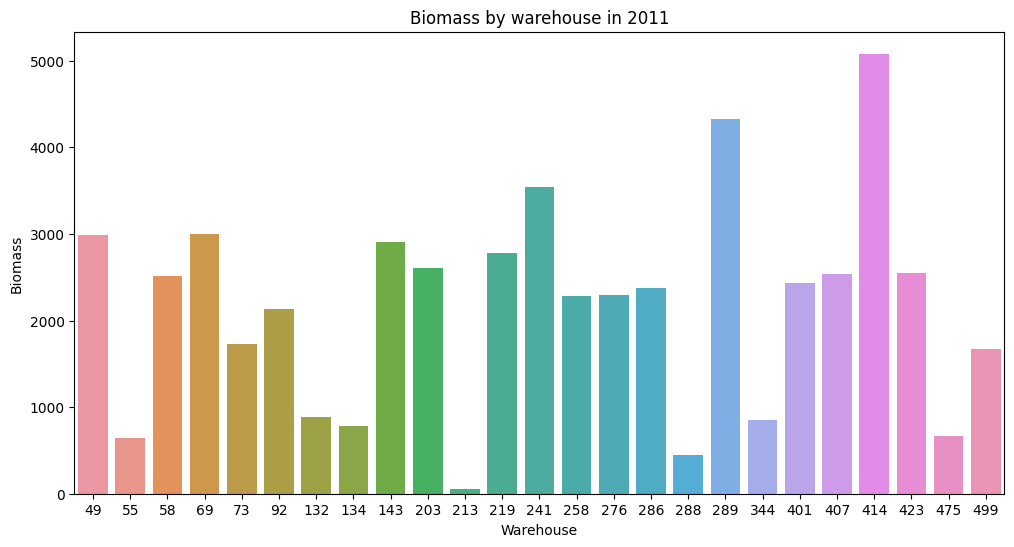

In [24]:
# plot the biomass by warehouse
plt.figure(figsize=(12, 6))
sns.barplot(x=biomass_by_warehouse.index, y=biomass_by_warehouse.values)
plt.title(f'Biomass by warehouse in {year}')
plt.xlabel('Warehouse')
plt.ylabel('Biomass')
plt.show()


In [27]:
solution[solution['selected'] == 1].sort_values('warehouse').head(50)

harvesting_site  warehouse  selected  2011_biomass
129934              333         49       1.0     77.892494
120434              316         49       1.0      0.557038
126934              328         49       1.0      0.493104
220934              498         49       1.0    189.260040
15434               127         49       1.0    161.123001
141434              354         49       1.0     39.585159
143934              359         49       1.0      0.163266
151934              373         49       1.0     32.455269
10934               119         49       1.0    105.337471
155434               37         49       1.0    184.534943
159434              387         49       1.0    157.361435
84434               251         49       1.0    102.294792
162934              393         49       1.0    186.222824
23434               141         49       1.0      0.465039
167434              400         49       1.0     88.144287
33934               160         49       1.0     70.339813
24934               144         49       1.0    113.733551
211934              481         49       1.0      0.260239
232934               69         49       1.0      7.292260
192934              447         49       1.0    272.569824
74434               233         49       1.0     31.810877
105434               28         49       1.0      9.022957
101434              282         49       1.0      8.839897
238934                7         49       1.0     91.215836
94934               270         49       1.0    198.898697
4934                108         49       1.0      5.773866
114934              306         49       1.0    353.641510
93434               268         49       1.0    214.213455
4434                107         49       1.0     67.695694
118434              312         49       1.0     69.789490
118934              313         49       1.0    135.794830
81434               246         49       1.0     10.006794
248451               97         55       1.0    164.727707
63451               213         55       1.0    169.593368
68451               222         55       1.0    143.620010
47451               185         55       1.0     87.488899
150451              370         55       1.0     83.253990
177454              419         58       1.0     51.417198
184954              432         58       1.0    241.987717
97454               275         58       1.0      9.073040
103954              287         58       1.0     20.562916
157954              384         58       1.0    166.223923
119454              314         58       1.0    130.069885
119954              315         58       1.0     17.851297
105954              290         58       1.0     12.861594
50954               191         58       1.0    152.077210
138454              349         58       1.0    228.770706
58454               204         58       1.0      0.017601
59454               206         58       1.0      0.273486
132454              338         58       1.0    307.089203

In [28]:
solution['HS_Longitude']= solution['harvesting_site'].apply(lambda idx: biomass_history['Longitude'][int(idx)])
solution['HS_Latitude']= solution['harvesting_site'].apply(lambda idx: biomass_history['Latitude'][int(idx)])
solution['W_Longitude']= solution['warehouse'].apply(lambda idx: biomass_history['Longitude'][int(idx)])
solution['W_Latitude']= solution['warehouse'].apply(lambda idx: biomass_history['Latitude'][int(idx)])
solution

harvesting_site  warehouse  selected  2011_biomass  HS_Longitude  \
0                     0          0       0.0      8.868568      71.33144   
1                     0          1       0.0      8.868568      71.33144   
2                     0         10       0.0      8.868568      71.33144   
3                     0        100       0.0      8.868568      71.33144   
4                     0        101       0.0      8.868568      71.33144   
...                 ...        ...       ...           ...           ...   
249995                9         95       0.0     68.375999      72.04807   
249996                9         96       0.0     68.375999      72.04807   
249997                9         97       0.0     68.375999      72.04807   
249998                9         98       0.0     68.375999      72.04807   
249999                9         99       0.0     68.375999      72.04807   

        HS_Latitude  W_Longitude  W_Latitude  
0          24.66818     71.33144    24.66818  
1          24.66818     71.41106    24.66818  
2          24.66818     72.12769    24.66818  
3          24.66818     71.96844    24.26518  
4          24.66818     72.04807    24.26518  
...             ...          ...         ...  
249995     24.66818     71.57031    24.26518  
249996     24.66818     71.64994    24.26518  
249997     24.66818     71.72956    24.26518  
249998     24.66818     71.80919    24.26518  
249999     24.66818     71.88882    24.26518  

[250000 rows x 8 columns]

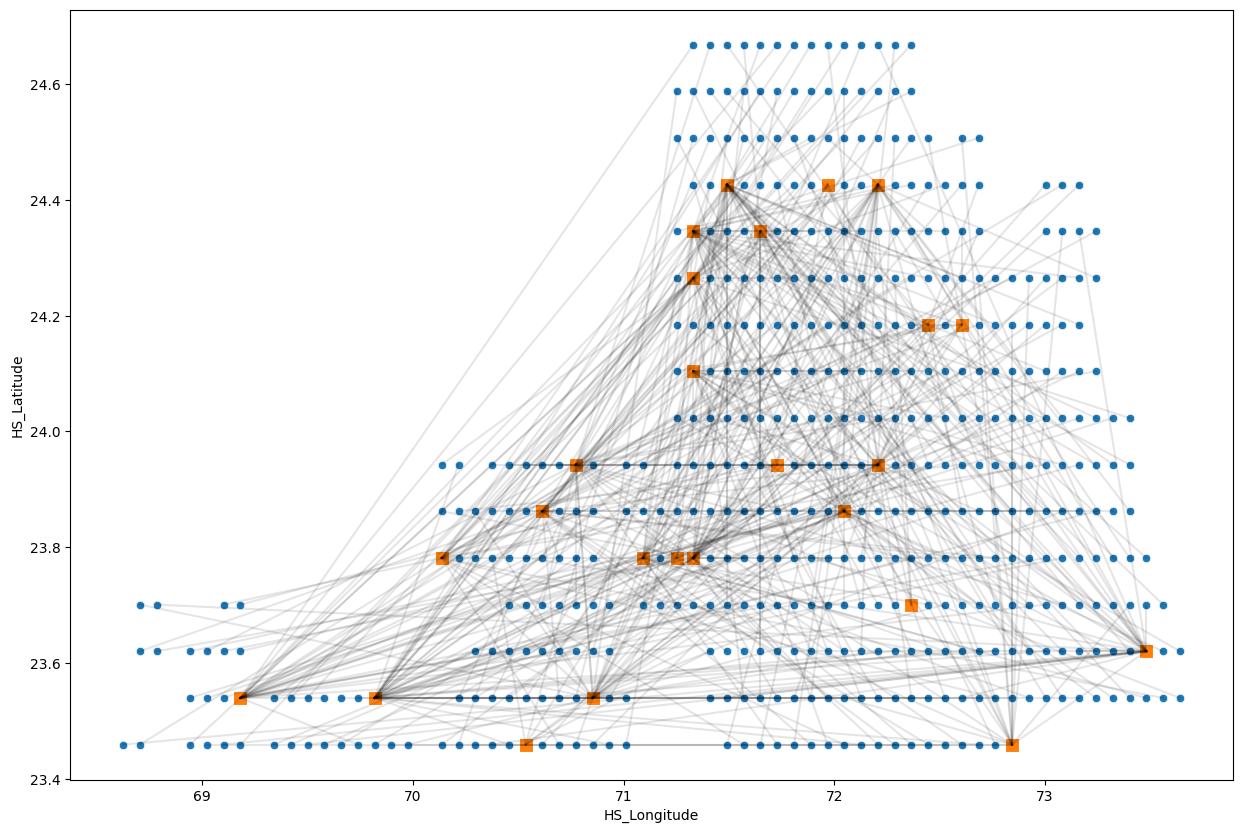

In [32]:
# Plotting the solution with seaborn
plt.figure(figsize=(15, 10))
sns.scatterplot(data=solution, x='HS_Longitude', y='HS_Latitude')
sns.scatterplot(data=solution[solution.selected==1], x='W_Longitude', y='W_Latitude', marker='s', s=100)

# plot the connections between harvesting sites and warehouses
for i in range(len(solution)):
    if solution.iloc[i]['selected'] == 1:
        plt.plot([solution.iloc[i]['HS_Longitude'], solution.iloc[i]['W_Longitude']], [solution.iloc[i]['HS_Latitude'], solution.iloc[i]['W_Latitude']], color='black', alpha=0.1)


plt.show()


In [61]:
# post optimization analysis

# get random configurations of the problem and calculate the objective function
def get_random_configurations(num_configurations):
    configurations = []
    for i in range(num_configurations):
        # randomly select the warehouses
        selected_warehouses = np.random.choice(warehouse_locations, num_warehouses, replace=False)
        # randomly create connections between harvesting sites and warehouses
        connections = []
        for j in selected_warehouses:
            for i in range(num_harvesting_sites):
                connections.append((i, np.random.choice(selected_warehouses, 1)[0]))

        configurations.append((selected_warehouses, connections))
    return configurations

def calculate_objective_function(configurations):
    objective_function_values = []
    for i in range(len(configurations)):
        selected_warehouses = configurations[i][0]
        connections = configurations[i][1]

        # calculate the cost of transportation
        cost_of_transportation = 0
        for connection in connections:
            cost_of_transportation += B[connection[0]] * D[connection[0]][connection[1]]

        
        # calculate the cost of underutilization
        cost_of_underutilization = 0
        for j in selected_warehouses:
            cost_of_underutilization += C - sum([B[i] for i in harvesting_sites if (i, j) in connections])
            
        print(cost_of_underutilization)
        # calculate the objective function
        a= 0.001
        b=1
        objective_function_values.append(a * cost_of_transportation + b * cost_of_underutilization)
    return objective_function_values

# get 100 random configurations
configurations = get_random_configurations(10)
# calculate the objective function for each configuration
objective_function_values = calculate_objective_function(configurations)
# plot the objective function values
plt.figure(figsize=(12, 6))
sns.histplot(objective_function_values, bins=20)
plt.title('Objective function values')
plt.xlabel('Objective function value')
plt.ylabel('Frequency')

# indicate my solution on the histogram
plt.show()


KeyboardInterrupt: 

In [36]:
pulp.value(prob.objective)

9999500.0